In [0]:
try:
    from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, LeakyReLU
    from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D, UpSampling2D, Conv2D,Conv2DTranspose
    from tensorflow.keras.models import Sequential, Model
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.optimizers import RMSprop
    from tensorflow.keras.initializers import RandomNormal
    from tensorflow.keras.constraints import Constraint
    from tensorflow.keras import backend as K
except: 
    from keras.layers import Input, Dense, Reshape, Flatten, Dropout, LeakyReLU
    from keras.layers import BatchNormalization, Activation, ZeroPadding2D, UpSampling2D, Conv2D,Conv2DTranspose
    from keras.models import Sequential, Model
    from keras.optimizers import Adam
    from keras.optimizers import RMSprop
    from keras.initializers import RandomNormal
    from keras.constraints import Constraint
    from keras import backend as K
import tensorflow as tf

import os
import argparse
import glob 

from PIL import Image
import matplotlib.pyplot as plt

import sys

import numpy as np


from keras import backend

# calculate wasserstein loss
def wasserstein_loss(y_true, y_pred):
	return backend.mean(y_true * y_pred)
 

#constraint class for gradient clipping
# clip model weights to a given hypercube
class ClipConstraint(Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value
 
	# clip model weights to hypercube
	def __call__(self, weights):
		return backend.clip(weights, -self.clip_value, self.clip_value)
 
	# get the config
	def get_config(self):
		return {'clip_value': self.clip_value}

class DCGAN():
    def __init__(self, img_rows=64, img_cols=64, channels=3, latent_dim=100, loss='binary_crossentropy', name='shipibo_64_black'):
        self.name = name

        # Input shape
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channels = channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = latent_dim
        self.loss = wasserstein_loss

        self.optimizer = RMSprop(lr=0.00005)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()

        # Build the generator
        self.generator = self.build_generator()

        # Build the GAN
        self.build_combined()
        
    def build_combined(self):
        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss=self.loss, optimizer=self.optimizer)    
    
    def load_weights(self, generator_file=None, discriminator_file=None):

        if generator_file:
            generator = self.build_generator()
            generator.load_weights(generator_file)
            self.generator = generator
    
        if discriminator_file:
            #discriminator = self.build_discriminator()
            self.discriminator.load_weights(discriminator_file)
            #self.discriminator = discriminator

        if generator_file or discriminator_file: 
            self.build_combined() 

        print("loaded model weights")

    def build_generator(self):

        init = RandomNormal(stddev=0.2)

        model = Sequential()
        #model.add(Dense(128, activation="relu", input_dim=self.latent_dim, name="generator_input") )
        #model.add(Dropout(0.1))
        
        #4,4
        model.add(Dense(512 * 4 * 4, activation="relu", input_dim=self.latent_dim, name="generator_input") )
        model.add(Dropout(0.30))
        model.add(Reshape((4, 4, 512)))
        

        #8,8
        model.add(Conv2DTranspose(256, kernel_size=4,strides=(2,2), kernel_initializer=init, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        

        16,16
        model.add(Conv2DTranspose(128, kernel_size=4,strides=(2,2),kernel_initializer=init, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        
        

        #32,32
        model.add(Conv2DTranspose(64, kernel_size=4,strides=(2,2),kernel_initializer=init, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        
        
        #64,64
        model.add(Conv2DTranspose(self.channels, kernel_size=4,strides=(2,2), padding="same", activation="tanh", kernel_initializer = init, name="generator_output"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img, name="generator")

    def build_discriminator(self):

        const = ClipConstraint(0.01)
        init = RandomNormal(stddev=0.2)

        model = Sequential()

        model.add(Conv2D(64, kernel_size=3, strides=2, kernel_initializer=init, kernel_constraint=const, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2D(128, kernel_size=3, strides=2, kernel_initializer=init, kernel_constraint=const, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.20))

        model.add(Conv2D(256, kernel_size=3, strides=2, kernel_initializer=init, kernel_constraint=const, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.20))

        model.add(Conv2D(512, kernel_size=3, strides=2, kernel_initializer=init, kernel_constraint=const, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.30))
        
        """ remove for 64 version
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        """
        model.add(Flatten())

        #model.add(Dense(32, activation='relu'))
        model.add(Dense(1, activation='linear'))

        model.summary()

        
        img = Input(shape=self.img_shape)
        validity = model(img)

        discrim = Model(img, validity)

        

        discrim.compile(loss=self.loss,
            optimizer=self.optimizer,
            metrics=['accuracy'])

        return discrim

    
    def normalize_images(self,im):
        return ((im + 1)/2.0)


    def train(self, X_train, epochs, batch_size=128, save_interval=100,batch_sample=5):

        # Adversarial ground truths


        #fixed noise points for using train images

        fixed_noise = np.random.normal(0, 1, ( 9 , self.latent_dim)) # generate 9 points
        train_imgs = []

        for epoch in range(epochs):
            
            #noisy labels for improved training
            #check if this has an effect on disc accuracy?
            valid =  -np.ones((batch_size, 1)) # - np.random.uniform(low=0.0, high=0.1, size=(batch_size, 1))
            fake = np.ones((batch_size, 1)) # + np.random.uniform(low=0.0, high=0.1, size=(batch_size, 1))
            
            # ---------------------
            #  Train Discriminator
            # ---------------------
            for i in range(5):
                # Select a random half of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]

                # Sample noise and generate a batch of new images
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                gen_imgs = self.generator.predict(noise)

                # Train the discriminator (real classified as ones and generated as zeros)
                d_loss_real = self.discriminator.train_on_batch(imgs, valid)
                d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            if epoch % 10 == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            if epoch % batch_sample == 0:
                #work on training animation
                epoch_imgs = self.generator.predict(fixed_noise)
                train_imgs.append(self.normalize_images(epoch_imgs)) 

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs( "images/{}_{:05d}.png".format(self.name,epoch) )
                # self.combined.save_weights("combined_weights ({}).h5".format(self.name)) # https://github.com/keras-team/keras/issues/10949
                self.generator.save("generator ({}).h5".format(self.name))
                self.discriminator.save("discriminator ({}).h5".format(self.name))


        return train_imgs

    def save_models(self):
        self.generator.save("generator ({}).h5".format(self.name))
        self.discriminator.save("discriminator ({}).h5".format(self.name))

    def save_imgs(self, name=''):
        r, c = 4, 4
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))

        # replace the first two latent variables with known values
        #for i in range(r):
        #    for j in range(c):
        #        noise[4*i+j][0] = i/(r-1)-0.5
        #        noise[4*i+j][1] = j/(c-1)-0.5

        gen_imgs = self.generator.predict(noise)
        gen_imgs = self.normalize_images(gen_imgs)

        fig, axs = plt.subplots(r, c, figsize=(6.72,6.72))
        plt.subplots_adjust(left=0.05,bottom=0.05,right=0.95,top=0.95, wspace=0.2, hspace=0.2)

        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i,j].axis('off')
                cnt += 1

        if name:
            fig.savefig(name, facecolor='white' )
        else: 
            fig.savefig('{}.png'.format(self.name), facecolor='black' )

        plt.close()
    

def export_model(saver, model, model_name, input_node_names, output_node_name):
    from tensorflow.python.tools import freeze_graph
    from tensorflow.python.tools import optimize_for_inference_lib
    
    if not os.path.exists('out'):
        os.mkdir('out')

    tf.train.write_graph(K.get_session().graph_def, 'out', model_name + '_graph.pbtxt')

    saver.save(K.get_session(), 'out/' + model_name + '.chkp')

    freeze_graph.freeze_graph('out/' + model_name + '_graph.pbtxt', None, False,
                              'out/' + model_name + '.chkp', output_node_name,
                              "save/restore_all", "save/Const:0",
                              'out/frozen_' + model_name + '.bytes', True, "")

    input_graph_def = tf.GraphDef()
    with tf.gfile.Open('out/frozen_' + model_name + '.bytes', "rb") as f:
        input_graph_def.ParseFromString(f.read())

    output_graph_def = optimize_for_inference_lib.optimize_for_inference(
            input_graph_def, input_node_names, [output_node_name],
            tf.float32.as_datatype_enum)

    with tf.gfile.FastGFile('out/opt_' + model_name + '.bytes', "wb") as f:
        f.write(output_graph_def.SerializeToString())

    print("graph saved!")



In [3]:
#load dataset
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


os.chdir("/content/drive/My Drive/GAN/Shipibo GAN/")
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
 animation
 anim_grid_2.mp4
 anim_grid_3.mp4
 anim_grid_dcgan_64_2.mp4
 anim_grid_dcgan_64.mp4
 anim_grid.mp4
'Copy of copy of DCGAN artificial art from github 64.ipynb'
'copy of DCGAN artificial art from github.ipynb'
'DCGAN 128.ipynb'
'discriminator (shipibo_128).h5'
'discriminator (shipibo_64_black).h5'
'discriminator (shipibo_64).h5'
'discriminator (shipibo).h5'
'generator (shipibo_128).h5'
'generator (shipibo_64_black).h5'
'generator (shipibo_64).h5'
'gen

https://github.com/googlecolab/colabtools/issues/287#issuecomment-517446876

measures when vm wont synch with drive



In [0]:
#drive.flush_and_unmount()

In [4]:

!mkdir imgs_64
!unzip -q preproc/64/0_compressed_black_64.zip -d imgs_64/


mkdir: cannot create directory ‘imgs_64’: File exists
replace imgs_64/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [0]:
!mkdir images

mkdir: cannot create directory ‘images’: File exists


In [5]:
from keras.preprocessing.image import load_img,img_to_array
from PIL import Image

def load_images(path,size=64,final_size=0):
    """ loads images into a numpy array and returns them
    """
    img_paths = [path + f  for f in os.listdir(path)]

    print(len(img_paths))

    if final_size== 0:
        final_size = len(img_paths)

    dataset_shape = (final_size ,size,size,3)

    data = np.ndarray(shape=dataset_shape)

    for i,f in enumerate(img_paths):
        with Image.open(f) as im:
            
            im = np.array(im)
            
            if i % 500 == 0:
                print("loaded ", i,"images" )

            data[i] = im.astype(int)

            if (i+1) % final_size == 0:

                return data
            
    print(data.shape)

    return data

data = load_images("imgs_64/",final_size=0)

#normalize data to tanh dim
data  = (data - 127.5) / 127.5

2400
loaded  0 images
loaded  500 images
loaded  1000 images
loaded  1500 images
loaded  2000 images


In [0]:
from matplotlib import animation

def animate_single_frame(train_imgs,index=0):
    

    ims = []
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1], frameon=False, aspect=1)
    ax.set_xticks([]); ax.set_yticks([])

    for train_ims in train_imgs:

        

        im_1 = plt.imshow(train_ims[0,:,:],vmin=0, vmax=1, animated=True) #add first image for test
        
        ims.append([im_1])
        #plt.pause(0.1) 

    mp4_writer =  animation.writers['ffmpeg']
    writer = mp4_writer(fps=24, metadata=dict(artist='Me'), bitrate=1800)


    anim = animation.ArtistAnimation(fig,ims)
    anim.save("test_gif_black_64.mp4", writer= writer)



In [17]:
preload_model = False

dcgan =  DCGAN(latent_dim=256) #create class

if preload_model:
    dcgan.load_weights(generator_file="generator (shipibo_64_black).h5",discriminator_file="discriminator (shipibo_64_black).h5")

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 17, 17, 128)       0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 17, 17, 128)       512       
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 17, 17, 128)       0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 17, 17, 128)      

In [18]:


train_imgs = dcgan.train(data,epochs=10000,batch_size=32,batch_sample=5)

animate_single_frame(train_imgs)

W0827 15:22:57.513303 140062400604032 training.py:2197] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
W0827 15:22:59.809873 140062400604032 training.py:2197] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


0 [D loss: -2.342330, acc.: 0.00%] [G loss: 3.582142]
10 [D loss: -58.701401, acc.: 0.00%] [G loss: 60.373600]
20 [D loss: -98.832916, acc.: 0.00%] [G loss: 99.887398]
30 [D loss: -132.827194, acc.: 0.00%] [G loss: 133.298828]
40 [D loss: -164.705261, acc.: 0.00%] [G loss: 164.604950]
50 [D loss: -196.197495, acc.: 0.00%] [G loss: 196.252655]
60 [D loss: -227.134918, acc.: 0.00%] [G loss: 226.922546]
70 [D loss: -259.198303, acc.: 0.00%] [G loss: 260.029175]
80 [D loss: -291.768311, acc.: 0.00%] [G loss: 292.219391]
90 [D loss: -324.192993, acc.: 0.00%] [G loss: 325.179626]
100 [D loss: -358.547424, acc.: 0.00%] [G loss: 358.052673]
110 [D loss: -392.462067, acc.: 0.00%] [G loss: 391.400513]
120 [D loss: -427.059174, acc.: 0.00%] [G loss: 426.834961]
130 [D loss: -461.105957, acc.: 0.00%] [G loss: 462.398193]
140 [D loss: -497.049286, acc.: 0.00%] [G loss: 497.819946]
150 [D loss: -532.774719, acc.: 0.00%] [G loss: 531.959656]
160 [D loss: -568.438293, acc.: 0.00%] [G loss: 568.729248]

KeyboardInterrupt: ignored

<function matplotlib.pyplot.show>

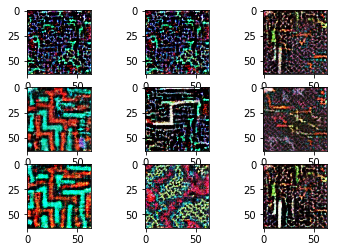

In [0]:

noise = np.random.normal(0, 1, ( 9 , dcgan.latent_dim)) # generate 9 points
imgs = dcgan.normalize_images(dcgan.generator.predict(noise))

for i in range(len(noise)):

    plt.subplot(3,3, i+1)
    plt.imshow(imgs[i])

plt.show


In [0]:


# starting point for every image
seed_start = np.random.normal(0, 1, (9, dcgan.latent_dim))

# these parameters will change every time step
latentSpeed = np.random.normal(3, 1, (9, dcgan.latent_dim))
vary = np.copy(seed_start)

# video settings
time = 0
fps = 30
maxTime = 10 # seconds
frameCount = 0

anim_imgs = []

while (time <= maxTime):

    # for each image
    for i in range(len(seed_start)): 
        
        # change the latent variables
        for j in range(dcgan.latent_dim):
            vary[i][j] = seed_start[i][j] + np.sin( 2*np.pi*(time/maxTime) * latentSpeed[i][j] ) 

    gen_imgs = dcgan.generator.predict(vary)

    anim_imgs.append(dcgan.normalize_images(gen_imgs))
    

    frameCount += 1
    time += .5/fps

(3, 3)


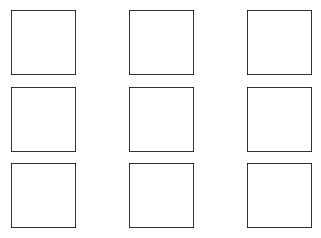

In [0]:
from matplotlib import animation

fig,axs = plt.subplots(3,3)

print(axs.shape)

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])

images = []

#iterate ove images
for imgs in anim_imgs:
    ims = [] 
    for i,img in enumerate(imgs):
        
        line = i%3
        col = int(i/3)
        ims.append(axs[line,col].imshow(img[:,:],vmin=0, vmax=1, animated=True))
    
    images.append(ims)

mp4_writer =  animation.writers['ffmpeg']
writer = mp4_writer(fps=24, metadata=dict(artist='Me'), bitrate=1800)

anim = animation.ArtistAnimation(fig,images)
anim.save("anim_grid_dcgan_64_2.mp4", writer= writer)